In [63]:
import pandas as pd
import numpy as np
import datetime
import gc
import random
from detect_sleep_states.import_data import import_data
from sklearn.cluster import KMeans
from xgboost import XGBClassifier, XGBRegressor

import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers


from tqdm import tqdm  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
merged_df, mappings = import_data("data/train_series.parquet","data/train_events.csv" )

/home/blinor/.cache/pypoetry/virtualenvs/detect-sleep-states-HW9MEIZd-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 4127301/4127301 [00:44<00:00, 92025.62it/s]
/home/blinor/.cache/pypoetry/virtualenvs/detect-sleep-states-HW9MEIZd-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 309/309 [00:00<00:00, 86041.29it/s]

100%|██████████| 310/310 [00:00<00:00, 178138.68it/s]


In [9]:
merged_df.info(), merged_df.memory_usage(deep=True)/1024/1024

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  uint16 
 1   step       uint32 
 2   anglez     float32
 3   enmo       float32
 4   seconds    uint32 
 5   day        uint8  
 6   month      uint8  
 7   year       uint8  
 8   weekday    uint8  
 9   event      int8   
 10  night      int16  
dtypes: float32(2), int16(1), int8(1), uint16(1), uint32(2), uint8(4)
memory usage: 3.0 GB


(None,
 Index          0.000122
 series_id    244.038277
 step         488.076553
 anglez       488.076553
 enmo         488.076553
 seconds      488.076553
 day          122.019138
 month        122.019138
 year         122.019138
 weekday      122.019138
 event        122.019138
 night        244.038277
 dtype: float64)

## XGBOOST


In [ ]:
train_x = []
train_y = []
limit = 0
for group, data in tqdm(merged_df.dropna().groupby("series_id")):
    train_x.extend(
        [window.values for window in data[["enmo","anglez"]].rolling(window=721, center=True) if len(window.values)==721])
    train_y.extend(
        [window.values[360] for window in data["event"].rolling(window=721, center=True) if len(window.values)==721])
    if limit >5:
        break
    else:
        limit+=1
        

In [ ]:
xgbr = XGBRegressor(tree_method="gpu_hist", device="gpu")
xgbr.fit(train_x, train_y)

In [ ]:
plt.plot(xgbr.predict(train_x[:37200]))
plt.plot(train_y[:37200])
plt.plot(merged_df.iloc[:37200]["enmo"])

## CNN

In [3]:
try: 
    merged_df = pd.read_parquet("merged.pqrt")
except:
    merged_df, mappings = import_data("data/train_series.parquet","data/train_events.csv" )
    merged_df.to_parquet("merged.pqrt")
merged_df
merged_df["minute"] = merged_df["seconds"]//60
merged_df["step"] = merged_df["step"]//60

,series_id,step,anglez,enmo,seconds,day,month,year,weekday,event,night
0,0,0,2.636700,0.0217,55800,14,8,1,1,-1,-1
1,0,1,2.636800,0.0215,55805,14,8,1,1,-1,-1
2,0,2,2.637000,0.0216,55810,14,8,1,1,-1,-1
3,0,3,2.636800,0.0213,55815,14,8,1,1,-1,-1
4,0,4,2.636800,0.0215,55820,14,8,1,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
127946335,276,592375,-27.277500,0.0204,875,8,9,0,4,1,34
127946336,276,592376,-27.032499,0.0233,880,8,9,0,4,1,34
127946337,276,592377,-26.841200,0.0202,885,8,9,0,4,1,34
127946338,276,592378,-26.723900,0.0199,890,8,9,0,4,1,34


In [4]:
reduced_df = merged_df.groupby(["series_id", "year", "month", "day", "minute"]).mean()

In [5]:
train= reduced_df.pivot_table(index=["step"], columns="series_id", values=["enmo","event"]).fillna(0)

In [6]:
train

enmo                                                    \
series_id       0         1         2         3         4         5     
step                                                                    
0.0        0.017342  0.016743  0.079960  0.006655  0.016322  0.006438   
1.0        0.013155  0.000000  0.070528  0.013843  0.015137  0.001170   
2.0        0.013482  0.017150  0.043428  0.058393  0.014537  0.001287   
3.0        0.014857  0.052253  0.067462  0.353903  0.015053  0.001223   
4.0        0.015842  0.160832  0.090833  0.081363  0.015728  0.001008   
...             ...       ...       ...       ...       ...       ...   
23893.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23894.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23895.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23896.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23897.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                                                   ... event                 \
series_id       6         7         8         9    ...   267  268  269  270   
step                                               ...                        
0.0        0.057960  0.074093  0.053630  0.210258  ...  -1.0 -1.0 -1.0 -1.0   
1.0        0.038348  0.073493  0.055422  0.097238  ...  -1.0 -1.0 -1.0 -1.0   
2.0        0.029765  0.077897  0.066097  0.101450  ...  -1.0 -1.0 -1.0 -1.0   
3.0        0.093760  0.082018  0.058827  0.095730  ...  -1.0 -1.0 -1.0 -1.0   
4.0        0.019277  0.066007  0.050753  0.051947  ...  -1.0 -1.0 -1.0 -1.0   
...             ...       ...       ...       ...  ...   ...  ...  ...  ...   
23893.0    0.000000  0.000000  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
23894.0    0.000000  0.000000  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
23895.0    0.000000  0.000000  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
23896.0    0.000000  0.000000  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
23897.0    0.000000  0.000000  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   

                                         
series_id  271  272  273  274  275  276  
step                                     
0.0       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
1.0       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2.0       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
3.0       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
4.0       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
...        ...  ...  ...  ...  ...  ...  
23893.0    0.0  0.0  0.0  0.0  0.0  0.0  
23894.0    0.0  0.0  0.0  0.0  0.0  0.0  
23895.0    0.0  0.0  0.0  0.0  0.0  0.0  
23896.0    0.0  0.0  0.0  0.0  0.0  0.0  
23897.0    0.0  0.0  0.0  0.0  0.0  0.0  

[23898 rows x 554 columns]

In [7]:
x = train["enmo"].T.values
y = train["event"].T.values
x[0], y[0], x.shape, y.shape

(array([0.01734167, 0.013155  , 0.01348167, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([-1., -1., -1., ...,  0.,  0.,  0.]),
 (277, 23898),
 (277, 23898))

In [38]:
x_train, x_test, y_train, y_test = train_test_split(train["enmo"].T.values,train["event"].T.values, test_size=0.3)
x_train.shape, x_test.shape

((193, 23898), (84, 23898))

In [68]:
model = models.Sequential()
model.add(layers.Conv1D(1, 720,padding="same", activation='relu', input_shape=(23898,1)))
model.add(layers.Conv1D(1, 120,padding="same", activation='relu'))
model.add(layers.Conv1D(1, 30,padding="same", activation='sigmoid'))
# Add dense layers on top
model.add(layers.Flatten())
# model.add(layers.Dense(y.shape[1], activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizers.Adam(0.1, weight_decay=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
metrics=["MSE", "MAE"])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 23898, 1)          721       
                                                                 
 conv1d_57 (Conv1D)          (None, 23898, 1)          121       
                                                                 
 conv1d_58 (Conv1D)          (None, 23898, 1)          31        
                                                                 
 flatten_21 (Flatten)        (None, 23898)             0         
                                                                 
Total params: 873 (3.41 KB)
Trainable params: 873 (3.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=20
                    )

Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 0.6081 - MSE: 0.2312 - MAE: 0.4575 - val_loss: 0.5411 - val_MSE: 0.2227 - val_MAE: 0.4141
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.5236 - MSE: 0.1926 - MAE: 0.3650 - val_loss: 0.5351 - val_MSE: 0.2200 - val_MAE: 0.3628
Epoch 3/10
 6/10 [=================>............] - ETA: 4s - loss: 0.5220 - MSE: 0.1976 - MAE: 0.3393

In [ ]:
for k, v in history.history.items():
    _=plt.plot(v, label=k)
_=plt.legend()

In [ ]:
pred = pd.DataFrame(model.predict(x_test), ).T

true=pd.DataFrame(y_test).T

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '60')

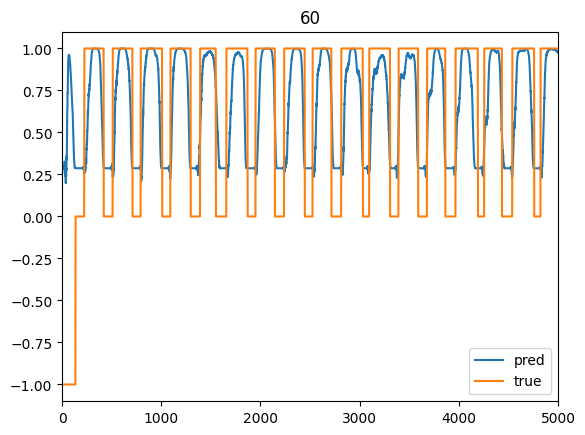

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '57')

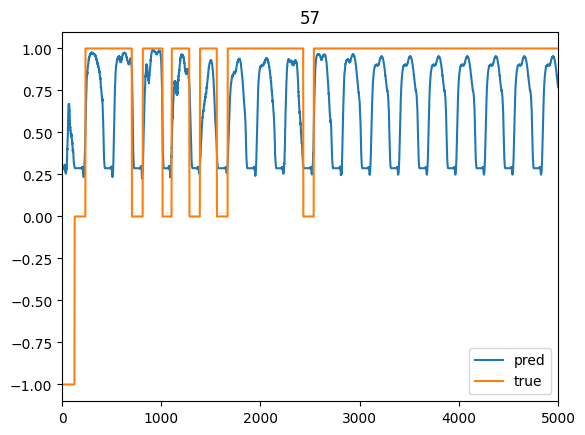

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '41')

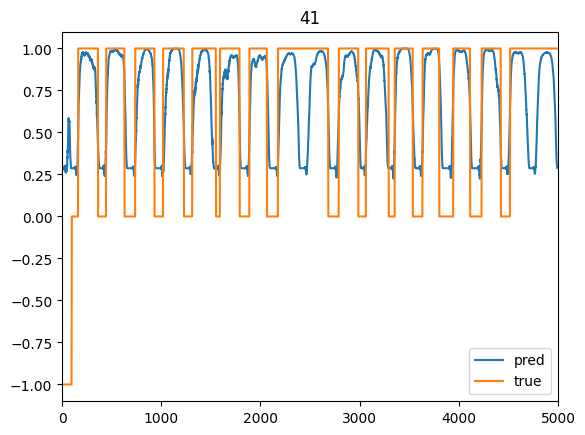

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '64')

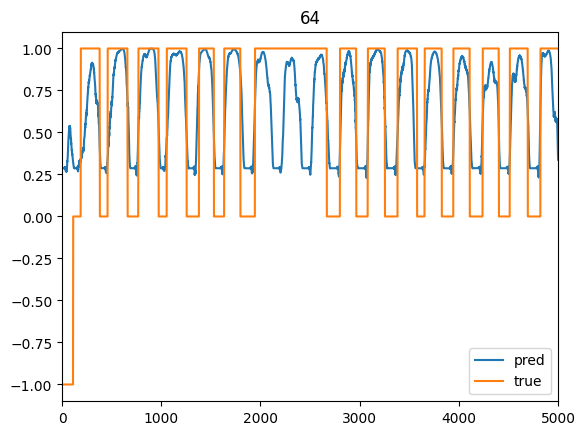

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '66')

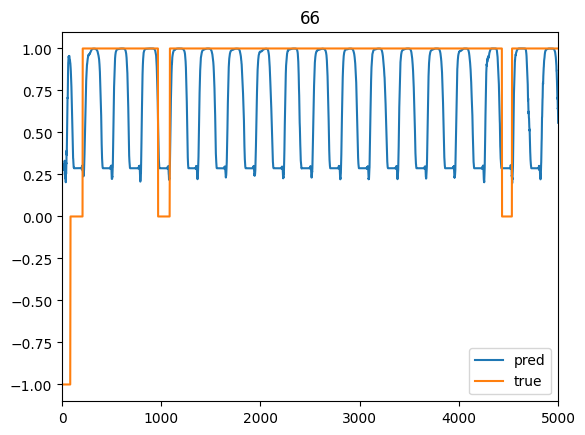

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '81')

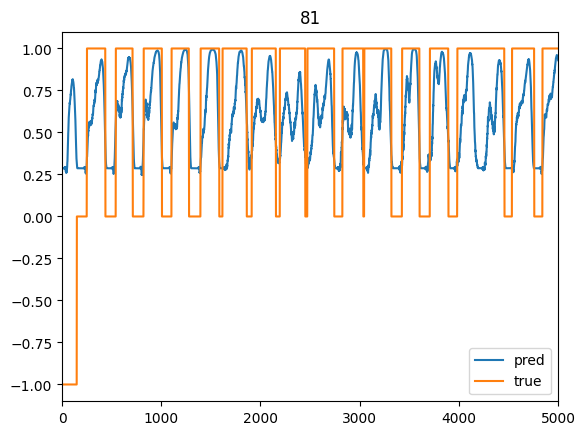

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '31')

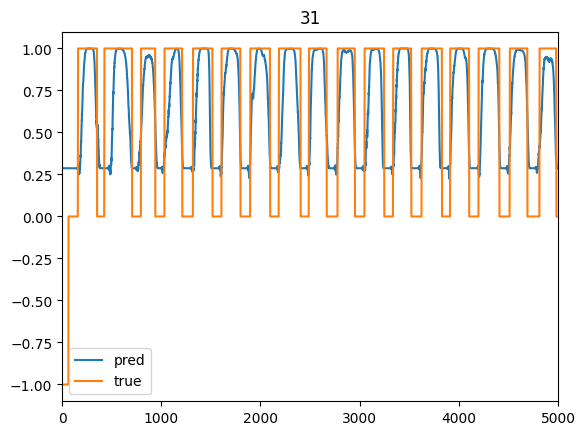

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '36')

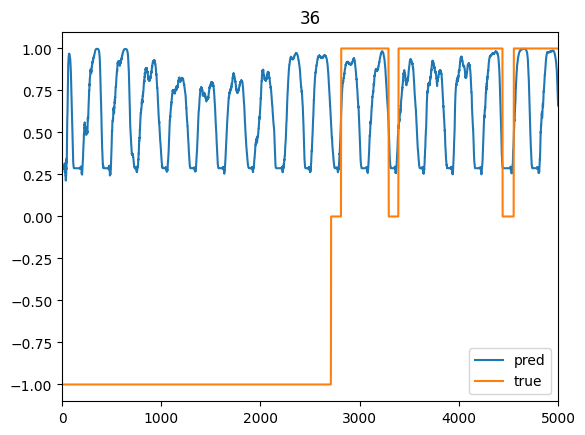

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '34')

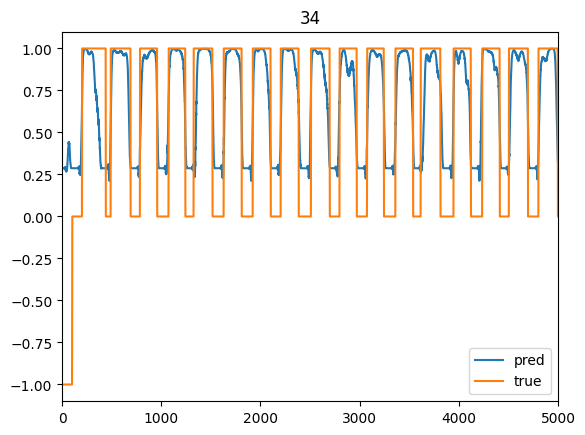

<Axes: >

(0.0, 5000.0)

Text(0.5, 1.0, '43')

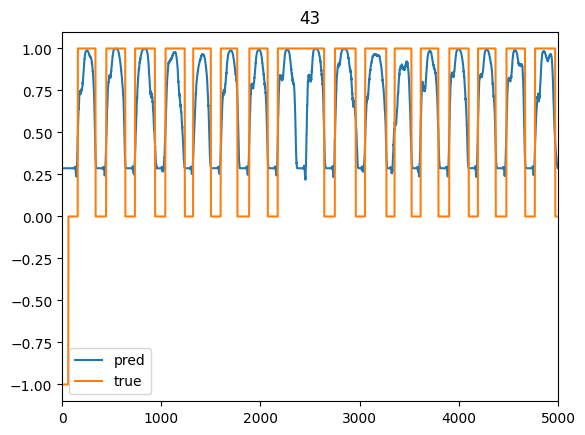

In [67]:
for series in random.choices(pred.columns,k= 10):
    ax=pred[series].plot(label="pred")
    _=true[series].plot(ax=ax, label="true")
    _=plt.legend()
    _=plt.xlim(0,5000)
    _=plt.title(str(series))
    _=plt.pause(0.1)